In [1]:
from pathlib import Path
import sys
import os
PRJ_ROOT = "/Users/mischa/Projects/FutureProofHomes/Satellite1-XMOS-15.3"
sys.path.append(str(PRJ_ROOT))
from orbit.audio.utils import read_wav_wave
from orbit.audio.analysis import estimate_time_delay
import numpy as np
import matplotlib.pyplot as plt

### Satellite1 with "nexus_demo_test" Firmware

In [4]:
RES_DIR = Path(".").parent / "results"/ "test_delayConfigs_fdPipeline_Sat1"
RUNS_PER_CASE = 5
test_cases = dict([ (int(case_dir.name.split("_")[-1]),case_dir) for case_dir in RES_DIR.iterdir() if case_dir.is_dir() ])

In [5]:
#load data into channels array [test_cases * run_per_test_case, channels, samples]
channels = np.empty((0,0,0))
for idx, dealy in enumerate(sorted(test_cases)):
    print(f"Case {idx+1} - Delay: {dealy}")
    case_dir = test_cases[dealy]
    runs = sorted(case_dir.glob("*.wav"))
    for run in runs:
        print(f"  Run {run.name}")
        fs, data = read_wav_wave( run.absolute().as_posix() )
        if channels.size == 0:
            channels = data[:,:, None].T
        else:
            if channels.shape[2] > data.shape[0]:
                channels = channels[:, :, :data.shape[0]]
            elif channels.shape[2] < data.shape[0]:
                data = data[:channels.shape[2], :]
            channels = np.vstack((channels, data[:,:,None].T))

Case 1 - Delay: -100
  Run test_r0.wav


Reading '/Users/mischa/Projects/FutureProofHomes/Satellite1-XMOS-15.3/batch_runs/aec/results/test_delayConfigs_fdPipeline_Sat1/test_delayConfigs_fdPipeline_Sat1_delayCfg_-100/test_r0.wav'...
Channels: 6, Sample Width: 2 bytes, Sample Rate: 16000 Hz, Frames: 926497
  Run test_r1.wav


Reading '/Users/mischa/Projects/FutureProofHomes/Satellite1-XMOS-15.3/batch_runs/aec/results/test_delayConfigs_fdPipeline_Sat1/test_delayConfigs_fdPipeline_Sat1_delayCfg_-100/test_r1.wav'...
Channels: 6, Sample Width: 2 bytes, Sample Rate: 16000 Hz, Frames: 926497
  Run test_r2.wav


Reading '/Users/mischa/Projects/FutureProofHomes/Satellite1-XMOS-15.3/batch_runs/aec/results/test_delayConfigs_fdPipeline_Sat1/test_delayConfigs_fdPipeline_Sat1_delayCfg_-100/test_r2.wav'...
Channels: 6, Sample Width: 2 bytes, Sample Rate: 16000 Hz, Frames: 926497
  Run test_r3.wav


Reading '/Users/mischa/Projects/FutureProofHomes/Satellite1-XMOS-15.3/batch_runs/aec/results/test_delayC

#### Raw Microphone Channels (4 & 5) 

In [6]:
mic_channel_mean_var = channels[:,[4,5],:].var(axis=2).mean(axis=1).reshape(len(test_cases), RUNS_PER_CASE)
channel4 = channels[:,4,:].reshape(len(test_cases), RUNS_PER_CASE, -1)
channel4_var = channel4.var(axis=2)
channel4_var /= mic_channel_mean_var
channel5 = channels[:,5,:].reshape(len(test_cases), RUNS_PER_CASE, -1)
channel5_var = channel5.var(axis=2)
channel5_var /= mic_channel_mean_var

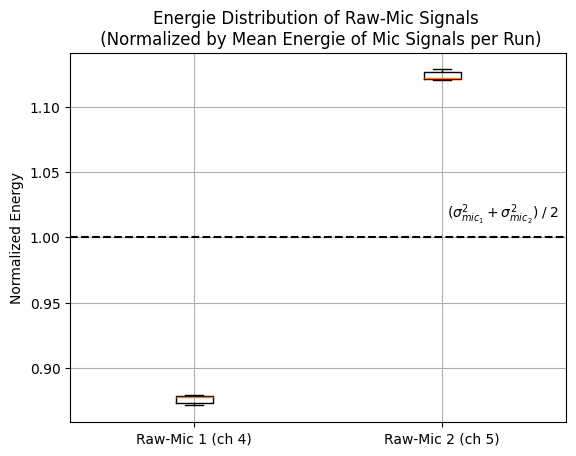

In [7]:
plt.boxplot( [channel4_var.flatten(), channel5_var.flatten()] );
plt.xticks([1,2], ["Raw-Mic 1 (ch 4)", "Raw-Mic 2 (ch 5)"]);
plt.axhline(1, color='black', linestyle='--');
plt.text(2.02, 1.015, "$(\sigma^2_{mic_1} + \sigma^2_{mic_2})\; / \; 2$", fontsize=10, color='black');
plt.title("Energie Distribution of Raw-Mic Signals \n (Normalized by Mean Energie of Mic Signals per Run)");
plt.ylabel("Normalized Energy");
plt.grid(True);

- Recordings of Mic2 are consistently about 10% higher than Mic1


In [11]:
np.mean((channel5_var - channel4_var/ channel4_var))

0.12335315828125497

### Processed Channel 1 (w/o Auto-Gain-Control)

In [12]:
#calc variances per run and normalize by mean variance of mic channels
channel1 = channels[:,1,:].reshape(len(test_cases), 5, -1)
channel1_var = channel1.var(axis=2)
channel1_var /= mic_channel_mean_var

In [13]:
#normalize each run by the mean over the test case
channel1_var_mean = channel1_var.mean(axis=1)
channel1_var_run_norm = channel1_var / channel1_var_mean[:,None]

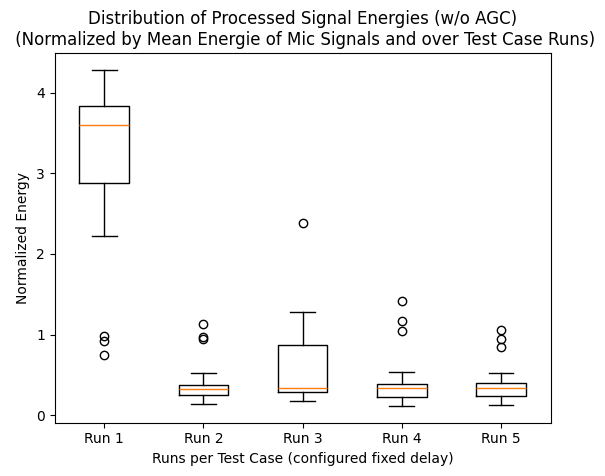

In [14]:
plt.title("Distribution of Processed Signal Energies (w/o AGC)\n (Normalized by Mean Energie of Mic Signals and over Test Case Runs)");
plt.boxplot( channel1_var_run_norm );
plt.xticks(range(1, RUNS_PER_CASE+1), [f"Run {i+1}" for i in range(RUNS_PER_CASE)]);
plt.xlabel("Runs per Test Case (configured fixed delay)");
plt.ylabel("Normalized Energy");

- the first run of a test case (after flashing, and hence resetting of the XMOS) has consistently a higher energy than later runs
- => algorithm needs time (samples) to estimate the parameter of the transfer channel model

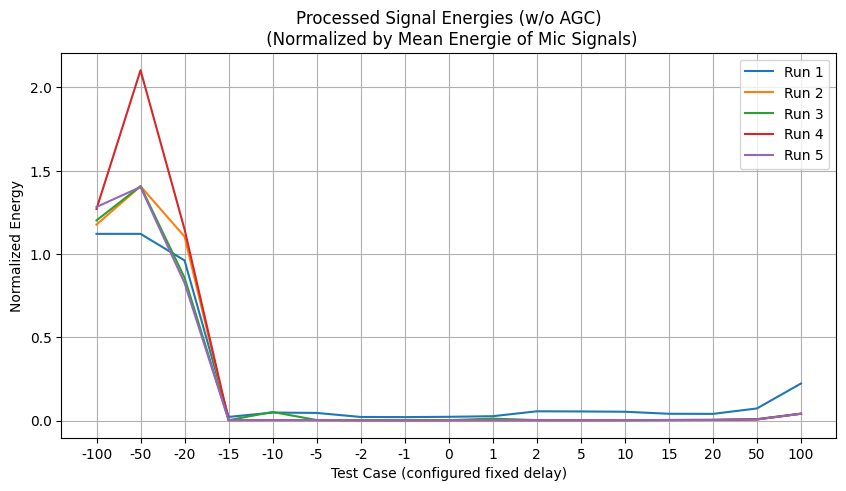

In [15]:
plt.figure(figsize=(10,5))
plt.title("Processed Signal Energies (w/o AGC)\n (Normalized by Mean Energie of Mic Signals)")
plt.plot(channel1_var);
plt.grid(True)
plt.xticks( np.arange(len(test_cases)), map(str, sorted(test_cases.keys())) );
plt.legend([f"Run {i+1}" for i in range(RUNS_PER_CASE)]);
plt.xlabel("Test Case (configured fixed delay)");
plt.ylabel("Normalized Energy");


(0.0, 0.007)

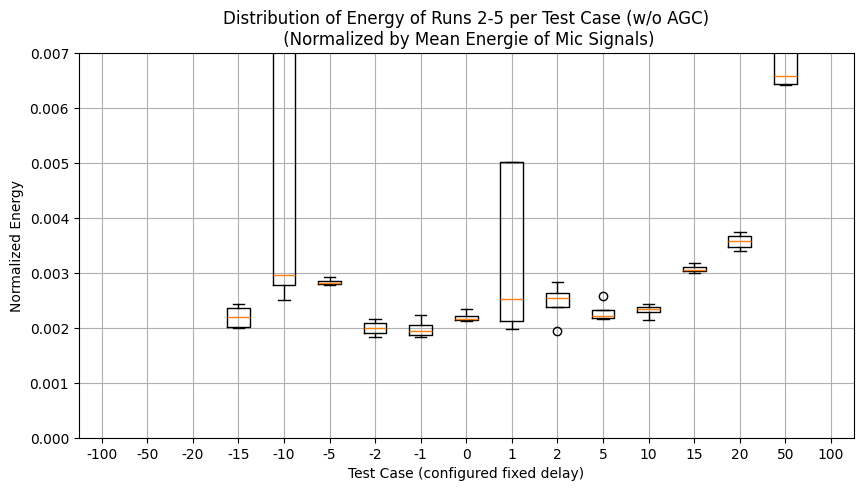

In [20]:
# Take only Runs 2-5 for each test case
plt.figure(figsize=(10,5))
plt.title("Distribution of Energy of Runs 2-5 per Test Case (w/o AGC)\n (Normalized by Mean Energie of Mic Signals)");
plt.boxplot(channel1_var[:,1:].T);
plt.grid(True)
plt.xticks( np.arange(1, len(test_cases)+1), map(str, sorted(test_cases.keys())) );
plt.xlabel("Test Case (configured fixed delay)");
plt.ylabel("Normalized Energy");
plt.ylim(0,0.007)


- for the cases -10, 1 and 50, probably sox (or the satellite) freezed and the XMOS needed to be restarted, hence the parameter needed time to adapt again will check that in the data... 

### Processed Channel 0 (with Auto-Gain-Control)

In [21]:
#calc variances per run and normalize by mean variance of mic channels
channel0 = channels[:,0,:].reshape(len(test_cases), RUNS_PER_CASE, -1)
channel0_var = channel0.var(axis=2)
channel0_var /= mic_channel_mean_var

In [22]:
#normalize each run by the mean over the test case
channel0_var_mean = channel0_var.mean(axis=1)
channel0_var_run_norm = channel0_var / channel0_var_mean[:,None]

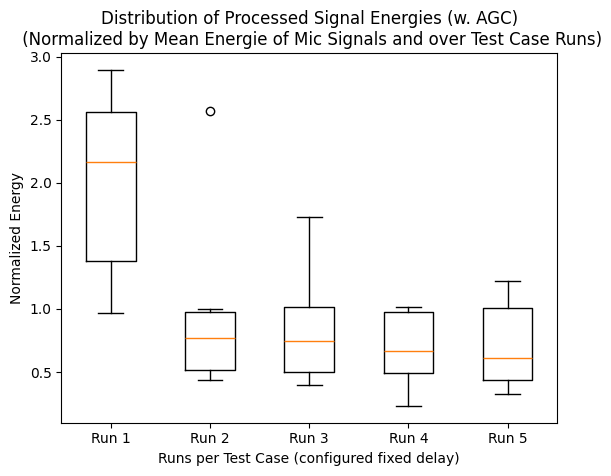

In [23]:
plt.title("Distribution of Processed Signal Energies (w. AGC)\n (Normalized by Mean Energie of Mic Signals and over Test Case Runs)");
plt.boxplot( channel0_var_run_norm );
plt.xticks(range(1, RUNS_PER_CASE+1), [f"Run {i+1}" for i in range(RUNS_PER_CASE)]);
plt.xlabel("Runs per Test Case (configured fixed delay)");
plt.ylabel("Normalized Energy");

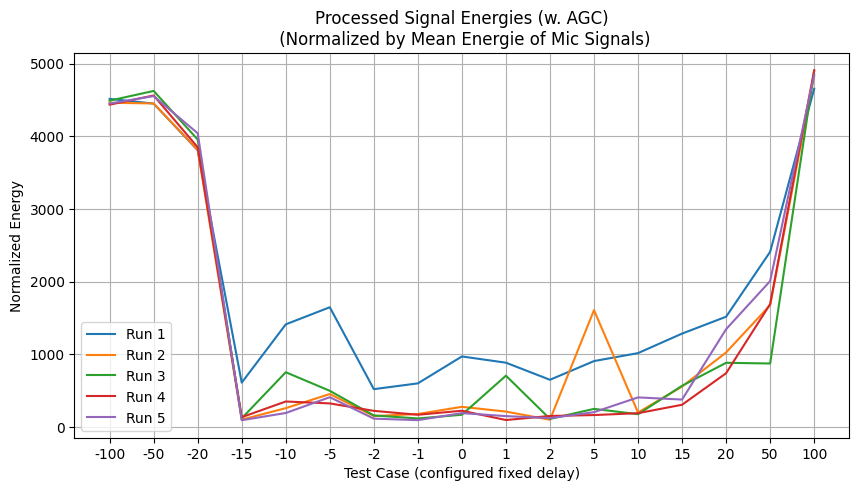

In [24]:
plt.figure(figsize=(10,5))
plt.title("Processed Signal Energies (w. AGC)\n (Normalized by Mean Energie of Mic Signals)")
plt.plot(channel0_var);
plt.grid(True)
plt.xticks( np.arange(len(test_cases)), map(str, sorted(test_cases.keys())) );
plt.legend([f"Run {i+1}" for i in range(RUNS_PER_CASE)]);
plt.xlabel("Test Case (configured fixed delay)");
plt.ylabel("Normalized Energy");

(0.0, 2000.0)

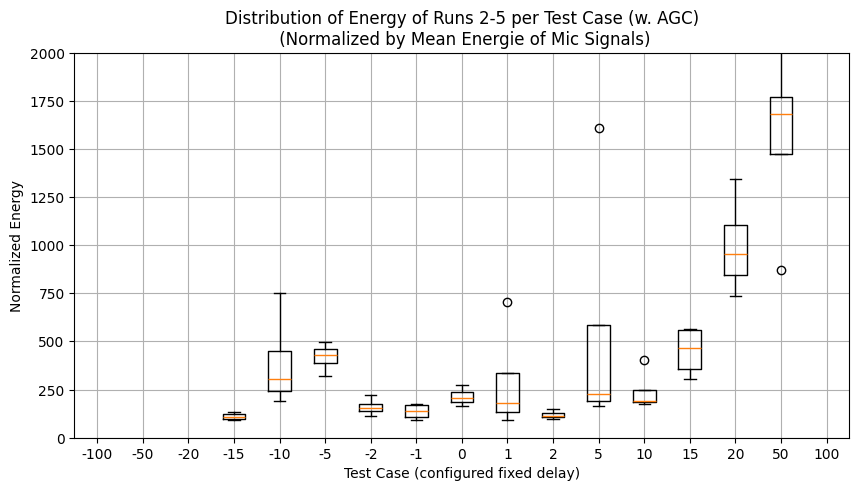

In [28]:
# Take only Runs 2-5 for each test case
plt.figure(figsize=(10,5))
plt.title("Distribution of Energy of Runs 2-5 per Test Case (w. AGC)\n (Normalized by Mean Energie of Mic Signals)");
plt.boxplot(channel0_var[:,1:].T);
plt.grid(True)
plt.xticks( np.arange(1, len(test_cases)+1), map(str, sorted(test_cases.keys())) );
plt.xlabel("Test Case (configured fixed delay)");
plt.ylabel("Normalized Energy");
plt.ylim(0,2000)


### Calculated Delay between Raw Mics and Reference Signals by Maximizing the Cross-Correlation
##### Example for Run 2 of Test-Case 0

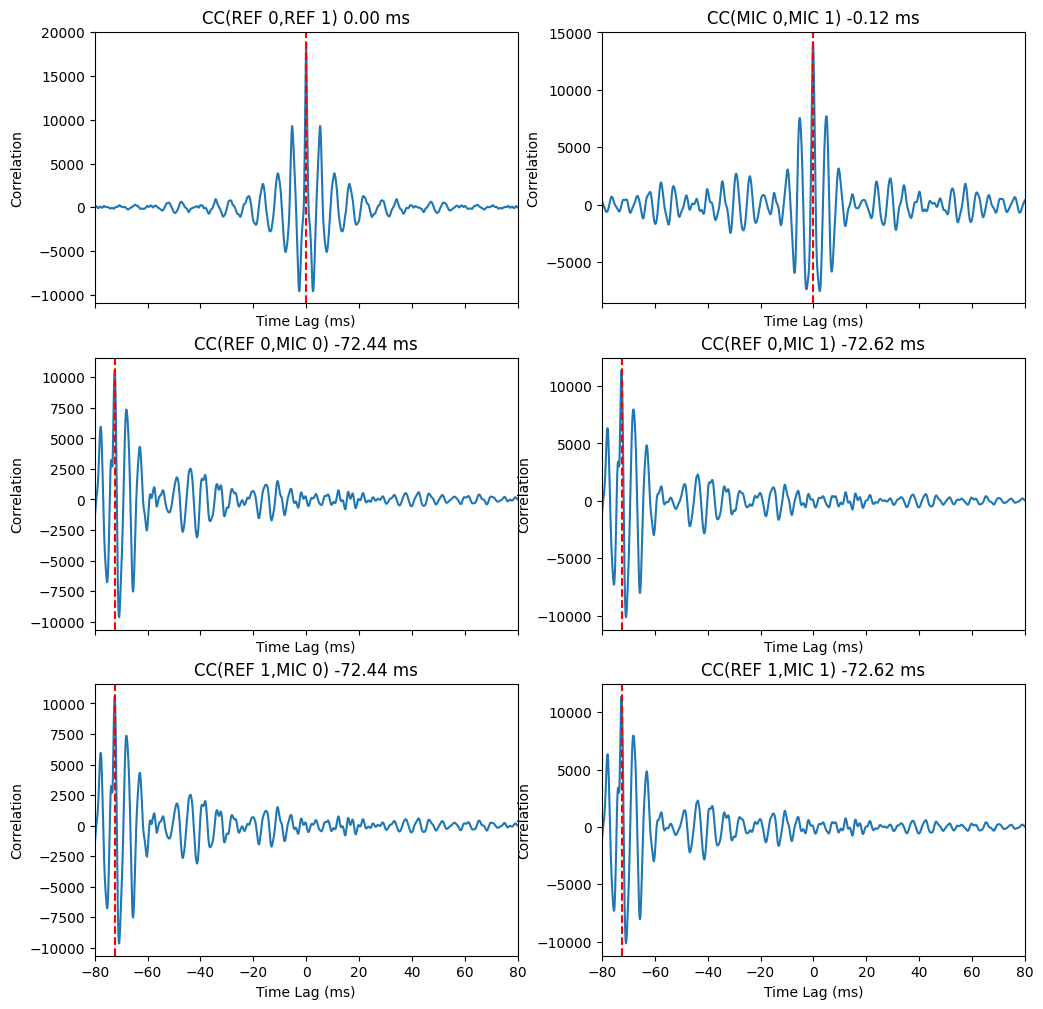

In [30]:
audio_data = channels[1,:,:].T
fs=16000
channel_names = [
    "PROC 0",
    "RPOC 1",
    "REF 0",
    "REF 1",
    "MIC 0",
    "MIC 1"
]
combinations = ((2,3),(4,5),(2,4),(2,5),(3,4),(3,5))
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True)
axes = axes.flatten()
for i, comb in enumerate(combinations):
    chirp_signal = audio_data[:,comb[0]] / np.max(audio_data[:,comb[0]])
    mic_signal = audio_data[:,comb[1]] / np.max(audio_data[:,comb[1]])
    # Estimate the delay
    estimated_delay_sec, correlation = estimate_time_delay(chirp_signal, mic_signal, fs)
    # Plot the cross-correlation
    lags = np.arange(-len(chirp_signal)+ 1, len(chirp_signal)) / fs

    axes[i].plot(lags * 1000, correlation)
    axes[i].axvline(x=estimated_delay_sec * 1000, color='r', linestyle='--', label=f"Estimated Delay: {estimated_delay_sec * 1000:.2f} ms")
    axes[i].set_title(f"CC({channel_names[comb[0]]},{channel_names[comb[1]]}) {estimated_delay_sec * 1000:.2f} ms")
    axes[i].set_xlabel("Time Lag (ms)")
    axes[i].set_ylabel("Correlation")
    axes[i].set_xlim((-80,80))

##### Does the measured delay depend on the configured fixed-delay?

Answer: Yes

Why is this different to the EXPLORER tests?

In [31]:
normed = channels / np.max(channels,axis=2)[:,:,None]
est_delays = []
for idx in range(channels.shape[0]):
    this_delays = []
    this_delays.append(estimate_time_delay(normed[idx,2,:], normed[idx,4,:], 16000)[0])
    this_delays.append(estimate_time_delay(normed[idx,2,:], normed[idx,4,:], 16000)[0])
    this_delays.append(estimate_time_delay(normed[idx,3,:], normed[idx,4,:], 16000)[0])
    this_delays.append(estimate_time_delay(normed[idx,3,:], normed[idx,5,:], 16000)[0])
    #this_delays.append(estimate_time_delay(normed[idx,4,:], normed[idx,5,:], 16000)[0])
    est_delays.append(this_delays)
    print(f"Estimated delay for case {idx} is {est_delays[idx]}")


Estimated delay for case 0 is [-0.0724375, -0.0724375, -0.0724375, -0.072625]
Estimated delay for case 1 is [-0.0724375, -0.0724375, -0.0724375, -0.072625]
Estimated delay for case 2 is [-0.0724375, -0.0724375, -0.0724375, -0.072625]
Estimated delay for case 3 is [-0.0724375, -0.0724375, -0.0724375, -0.072625]
Estimated delay for case 4 is [-0.0724375, -0.0724375, -0.0724375, -0.072625]
Estimated delay for case 5 is [-0.029125, -0.029125, -0.029125, -0.0293125]
Estimated delay for case 6 is [-0.029125, -0.029125, -0.029125, -0.0293125]
Estimated delay for case 7 is [-0.0293125, -0.0293125, -0.0293125, -0.0295]
Estimated delay for case 8 is [-0.0293125, -0.0293125, -0.0293125, -0.0295]
Estimated delay for case 9 is [-0.0293125, -0.0293125, -0.0293125, -0.0295]
Estimated delay for case 10 is [-0.0026875, -0.0026875, -0.0026875, -0.002875]
Estimated delay for case 11 is [-0.0026875, -0.0026875, -0.0026875, -0.002875]
Estimated delay for case 12 is [-0.0026875, -0.0026875, -0.0026875, -0.0

(-10.0, 20.0)

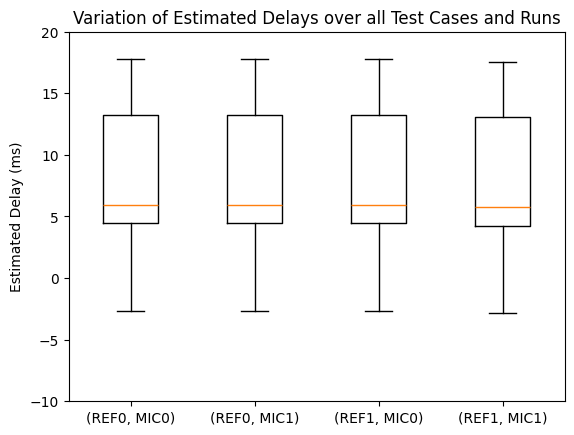

In [34]:
plt.title("Variation of Estimated Delays over all Test Cases and Runs")
plt.boxplot(np.array(est_delays)*1000);
plt.ylabel("Estimated Delay (ms)");
plt.xticks(range(1,5), ["(REF0, MIC0)", "(REF0, MIC1)", "(REF1, MIC0)", "(REF1, MIC1)"]);
plt.ylim(-10,20)

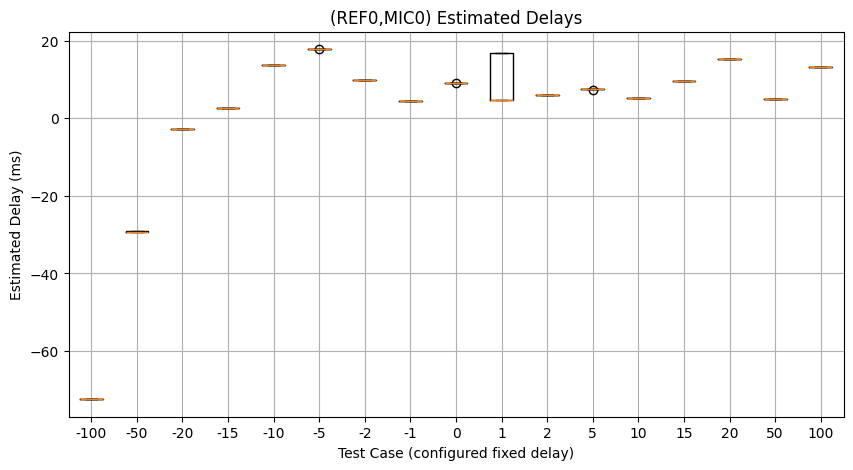

In [49]:
plt.figure(figsize=(10,5))
plt.title("(REF0,MIC0) Estimated Delays")
plt.boxplot(np.array(est_delays)[:,0].reshape(len(test_cases),-1).T*1000);
plt.grid(True)
plt.ylabel("Estimated Delay (ms)");
plt.xticks( np.arange(1, len(test_cases)+1), map(str, sorted(test_cases.keys())) );
plt.xlabel("Test Case (configured fixed delay)");

(-5.0, 20.0)

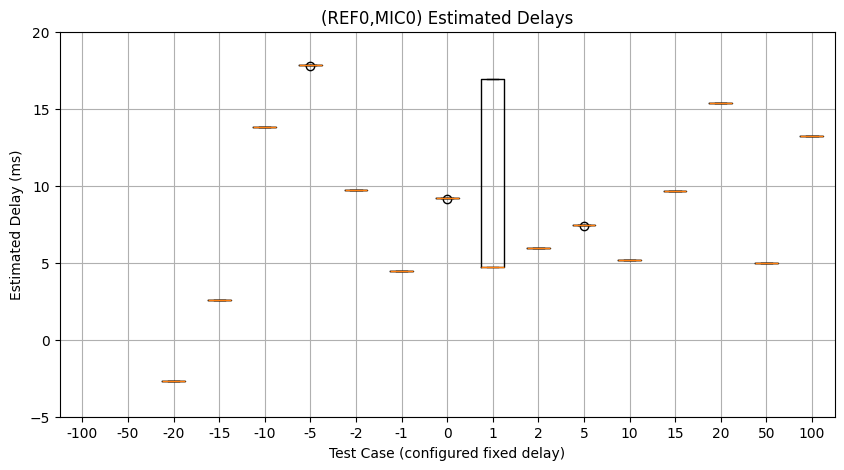

In [50]:
plt.figure(figsize=(10,5))
plt.title("(REF0,MIC0) Estimated Delays")
plt.boxplot(np.array(est_delays)[:,0].reshape(len(test_cases),-1).T*1000);
plt.grid(True)
plt.ylabel("Estimated Delay (ms)");
plt.xticks( np.arange(1, len(test_cases)+1), map(str, sorted(test_cases.keys())) );
plt.xlabel("Test Case (configured fixed delay)");
plt.ylim(-5,20)

#### Further Analysis